In [1]:
import random
from collections import Counter
from pathlib import Path

import albumentations as A
import cv2
import numpy as np
import torch
from tqdm.auto import tqdm

from src.data import IDAOData

# Datasets

Here's how the original dataset folder (`idao_dataset`) looks like:

In [2]:
! tree idao_dataset -d

idao_dataset
├── private_test
├── public_test
└── train
    ├── ER
    └── NR

5 directories


We will take all the images from the `train` directory, and create our train, validation and test (plus test houldout) set in the `data` folder

In [3]:
! export PYTHONPATH="$PWD" && python scripts/create_datasets.py

Data already exists.


In [4]:
! tree data -d

data
├── test
├── test_holdout
├── train
└── val

4 directories


Here 
- `train` dataset has 90% of the original train data
- `test` and `val` both 5%,
- and `test_holdout` consists of those rare energy/type combinations that are otherwise missing form the original train set. 

Below you'll see a more details enumeration of the contents of the datasets.

In [5]:
# New directories
data_root = Path("data")

train_dir = data_root / "train"
val_dir = data_root / "val"
test_dir = data_root / "test"
test_holdout_dir = data_root / "test_holdout"

# Check new datasets
train_ds = IDAOData(train_dir)
val_ds = IDAOData(val_dir)
test_ds = IDAOData(test_dir)
test_holdout_ds = IDAOData(test_holdout_dir)

In [6]:
Counter(train_ds.classes)

Counter({('ER', 10): 2031,
         ('NR', 20): 1986,
         ('ER', 3): 2037,
         ('NR', 1): 1962,
         ('ER', 30): 2022,
         ('NR', 6): 2018})

In [7]:
Counter(val_ds.classes)

Counter({('NR', 6): 120,
         ('ER', 30): 100,
         ('NR', 1): 104,
         ('ER', 10): 111,
         ('NR', 20): 112,
         ('ER', 3): 109})

In [8]:
Counter(test_ds.classes)

Counter({('NR', 20): 110,
         ('ER', 3): 97,
         ('ER', 10): 130,
         ('NR', 1): 111,
         ('NR', 6): 117,
         ('ER', 30): 116})

In [9]:
Counter(test_holdout_ds.classes)

Counter({('ER', 20): 2,
         ('NR', 10): 2,
         ('NR', 30): 2,
         ('ER', 1): 3,
         ('ER', 6): 1,
         ('NR', 3): 2})

## Test some images - classes

Let's check for each class what the images look like

In [10]:
import matplotlib.pyplot as plt
random.seed(42)

full_dataset = IDAOData('idao_dataset/train')

In [11]:
e1 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 1]
e3 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 3]
e6 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 6]
e10 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 10]
e20 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 20]
e30 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 30]
ER = [idx for idx, icls in enumerate(full_dataset.classes) if icls[0] == 'ER']
NR = [idx for idx, icls in enumerate(full_dataset.classes) if icls[0] == 'NR']

indices = [e1, e3, e6, e10, e20, e30, ER, NR]
titles = [f'Energy {i}' for i in (1, 3, 6, 10, 20, 30)] + ['ER', 'NR']

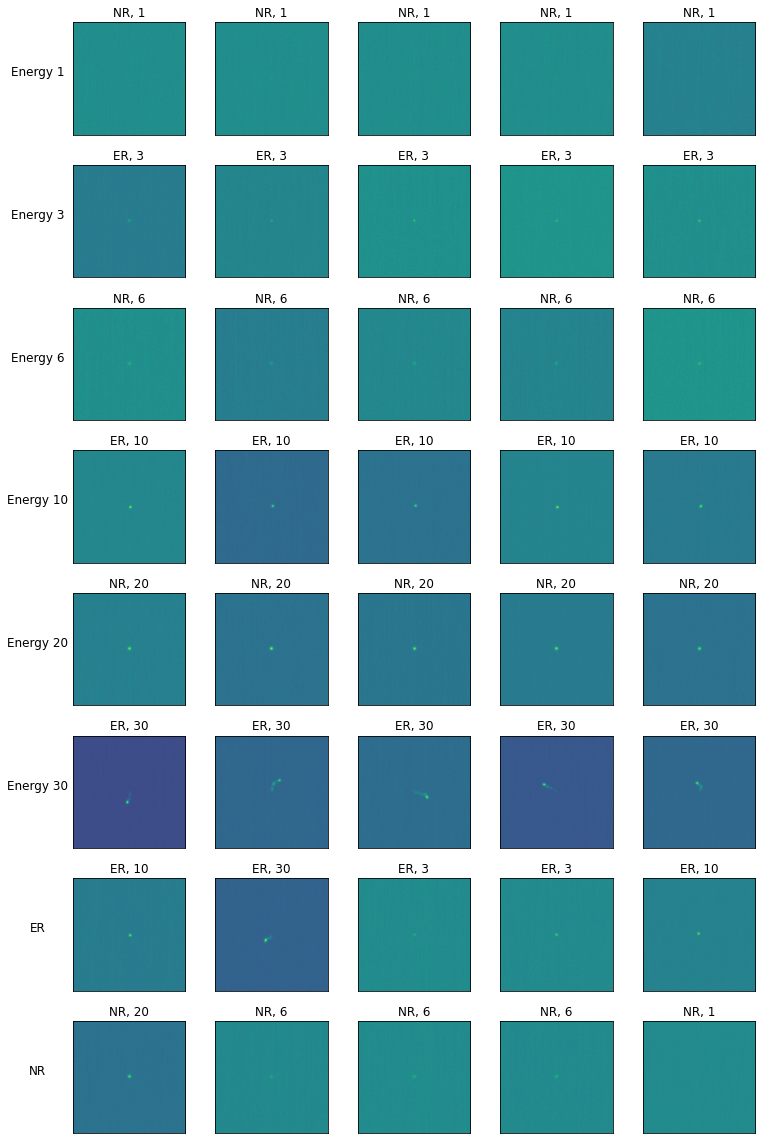

In [12]:
N = 5
fig, axes = plt.subplots(len(titles), N, figsize = (N*2.2, len(titles)*2))

for idx, (inds, title) in enumerate(zip(indices, titles)):
    axes[idx, 0].set_ylabel(title, rotation=0, size='large', labelpad=35)
    for j in range(N):
        ax = axes[idx, j]
        img, r_type, energy = full_dataset[random.choice(inds)]
        ax.set_title(f'{"NR" if r_type else "ER"}, {energy}')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.imshow(img)
        
fig.tight_layout()
fig.savefig('_assets/classes.png', bbox_inches='tight', pad_inches=0)

## Test some images - matrix

Let's make the contrast more apparent in matrix form

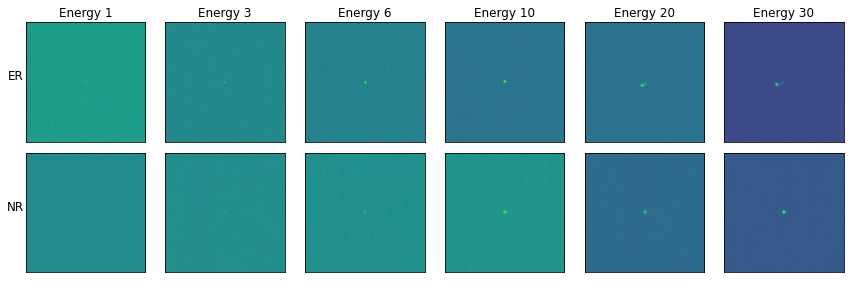

In [29]:
fig, axes = plt.subplots(2, 6, figsize=(6*2, 2*2))

for i, r_type in enumerate(['ER', 'NR']):
    for j, energy in enumerate([1, 3, 6, 10, 20, 30]):
        ax = axes[i, j]
        ids = [idx for idx, icls in enumerate(full_dataset.classes) if icls == (r_type, energy)]
        ax.imshow(full_dataset[random.choice(ids)][0])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

for r_type, ax in zip(['ER', 'NR'], axes[:, 0]):
    ax.set_ylabel(f'{r_type}', size='large', labelpad=10, rotation=0)

for energy, ax in zip([1, 3, 6, 10, 20, 30], axes[0, :]):
    ax.set_title(f'Energy {energy}', size='large')                         

fig.tight_layout()
fig.savefig('_assets/comb_classes.png', bbox_inches='tight', pad_inches=0)

# Dataloader

Here we'll prepare some calculations and transformations for the dataloader

## Calculate mean and std for transformation

In [14]:
mean = 0.0
var = 0.0

# Calculate mean
for img, _, _ in tqdm(full_dataset, desc='Calculating mean'):
    mean += img.sum() / (255 * len(full_dataset) * img.size)
    
# Calculate var
for img, _, _ in tqdm(full_dataset, desc='Calculating var'):
    var += ((img/255 - mean)**2).sum() / (len(full_dataset) * img.size)

print(f'{mean=}, {var=}')

Calculating mean:   0%|          | 0/13405 [00:00<?, ?it/s]

Calculating var:   0%|          | 0/13405 [00:00<?, ?it/s]

mean=0.39376788022420933, var=0.00019957727656703597


Because the variance is so small (std equals about 0.015) I will try first not to divide by it, and then try different numbers to see if this improves (there should still be some scaling).